Get the implicit utility function.

In [1]:
struct Calibration
    σ::Float64           #elasticity of relative demand with respect to price         
    γ::Vector{Float64}   #intensity in each good
    ϵ::Vector{Float64}   #elasticity of relative demand with respect to income in luxury good sector
    κ::Vector{Float64}   #For Stone and Geary
    p::Vector{Float64}
end


In [2]:
cal = Calibration(
    0.5,                    # sigma=0.5 completementary goods
    [1/3, 1/3, 1/3],        #intensity
    [0.8, 1.0, 1.2],       #ELASTICITIES
    [0.05, 0.03, 0.02],     #For Stone and Geary
    [1.0, 1.0, 1.0]
)

Calibration(0.5, [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], [0.8, 1.0, 1.2], [0.05, 0.03, 0.02], [1.0, 1.0, 1.0])

In [3]:
ρ=(cal.σ-1)/cal.σ

-1.0

In [5]:
#Function CES
function CES(C::Vector{Int64}, cal)
    U=sum(cal.γ[i]*C[i]^ρ for i=1:length(C))^(1/ρ)
    return U
end

CES (generic function with 1 method)

In [7]:
#Function Stone and Geary
function SG(C::Vector{Int64}, cal)
    U=sum(cal.γ[i]*(C[i]+cal.κ[i])^ρ for i=1:length(C))^(1/ρ)
    return U
end

SG (generic function with 1 method)

In [86]:
using NLsolve
u=1

#UTILITY LEVEL for a given C
function solvingNH(u, C::Vector{Float64}, cal)
    out=sum(cal.γ[i]^(1/cal.σ)*(C[i]/u^(cal.ϵ[i]))^ρ for i=1:length(C))-1
    return out
end

function NHUtility(u,C::Vector{Float64},cal)
    u=1.0
    res = nlsolve(u->[solvingNH(u[1], C, cal)], [1.0])
    U=res.zero[1]
    return U
end

#EXPENDITURE FUNCTION
function Expenditure(u,C,cal)
    U= NHUtility(u,C,cal)
    Exp=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (cal.p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    return Exp
end


#Consumption function
function Consumption_and_share(u,C,cal)
    U=NHUtility(u,C,cal)
    E=Expenditure(u,C,cal)
    
    #CONS
    C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(-cal.σ)

    #SHARE
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(1-cal.σ)

    return [C1, C2, C3, ω_p, ω_n, ω_l]
end

Consumption_and_share (generic function with 1 method)

In [90]:
u=[]
C_p=[]
C_n=[]
C_l=[]
expend=[]
c_s=[]

scale=2
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res = nlsolve(u->[solvingNH(u[1], [i, j, k], cal)], [1.0])
            U=res.zero[1]
            u=push!(u,U)

            #Exp
            exp= Expenditure(u,[i,j,k],cal)
            expend=push!(expend,exp)

            #Share
            cons_share=Consumption_and_share(u,[i,j,k],cal)
            c_s=push!(c_s,cons_share)


            C_p=push!(C_p,i)
            C_n=push!(C_n,j)
            C_l=push!(C_l,k)
        end
    end
end

[u c_s]

8×2 Matrix{Any}:
 2.95363  [0.886942, 0.988395, 1.10145, 0.297952, 0.332034, 0.370014]
 3.72026  [1.09368, 1.24723, 1.42234, 0.29062, 0.331424, 0.377956]
 3.51093  [1.03762, 1.17647, 1.3339, 0.292453, 0.331588, 0.375959]
 4.69928  [1.35259, 1.57895, 1.8432, 0.28328, 0.330689, 0.386031]
 3.37407  [1.00082, 1.13024, 1.2764, 0.293714, 0.331696, 0.37459]
 4.40257  [1.27464, 1.47829, 1.71447, 0.285321, 0.330906, 0.383773]
 4.08632  [1.19108, 1.37112, 1.57837, 0.287661, 0.331143, 0.381196]
 5.76196  [1.62862, 1.94034, 2.31172, 0.276945, 0.329952, 0.393104]

In [18]:
function f!(F::Any, v::Vector{Float64},cal)
    C=[v[1],v[2],v[3]]
    
    F[1]=cal.γ[1]*NHUtility(u,C,cal)^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/v[4])^(-cal.σ)^(-cal.σ)-v[1]
    F[2]=cal.γ[2]*NHUtility(u,C,cal)^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/v[4])^(-cal.σ)^(-cal.σ)-v[2]
    F[3]=cal.γ[3]*NHUtility(u,C,cal)^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/v[4])^(-cal.σ)^(-cal.σ)-v[3]
    F[4]=sum(cal.γ[i]*NHUtility(u,C,cal)^(cal.ϵ[i]*(1-cal.σ)) * (cal.p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))-v[4]
end

f! (generic function with 2 methods)

In [19]:
res = nlsolve((F,v) -> f!(F, v, cal), [10.0, 10.0, 10.0, 445.0])
res

DomainError: DomainError with -0.5:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [27]:
u=[]
C_1=[]
C_2=[]
C_3=[]

scale=10
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res = nlsolve(u->[solvingNH(u[1], [i, j, k], cal)], [1.0])
            U=res.zero[1]
            u=push!(u,U)
            C_1=push!(C_1,i)
            C_2=push!(C_2,j)
            C_3=push!(C_3,k)
        end
    end
end
[u C_1 C_2 C_3]

1000×4 Matrix{Real}:
  2.95363   1   1   1
  3.72026   1   1   2
  4.09805   1   1   3
  4.32445   1   1   4
  4.47557   1   1   5
  4.58369   1   1   6
  4.66492   1   1   7
  4.72819   1   1   8
  4.77887   1   1   9
  4.82039   1   1  10
  ⋮                
  9.49359  10  10   2
 12.6116   10  10   3
 15.2743   10  10   4
 17.6028   10  10   5
 19.6707   10  10   6
 21.5278   10  10   7
 23.21     10  10   8
 24.7442   10  10   9
 26.1516   10  10  10

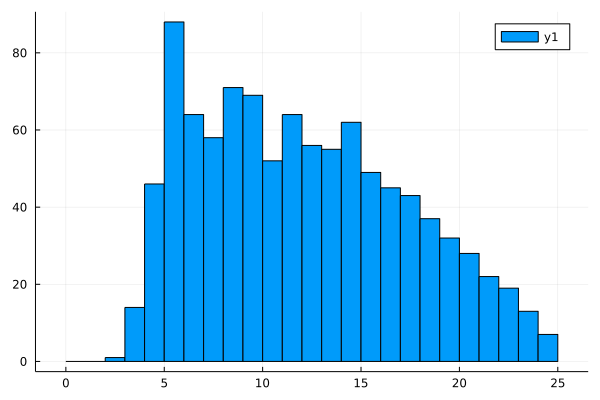

In [28]:
using Plots, Distributions
plot(u)
histogram(u; bins = 0:1:25)
